# Perzeptron: Vergleich von unverändertem Trainingset, Undersampling und Under/Oversampling
- Testset: Durch Undersampling gleichverteilt über Farbkategorien
- Ergebnisse: 
    - Starke Frequenzeffekte, wenn unverändertes Trainingsset
        - Tendenz zu frequenten Farbkategorien; Probleme für weniger frequente Farbkategorien
    - Konsistentere Ergebnisse, wenn Trainingsset gleichverteilt über Farbkategorien
        - Probleme mit Graustufen: Viele unbunte Farben als bunte Farben eingeordnet
        - keine großen Unterschiede zwischen Undersampling und Kombination aus Under- und Oversampling

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
import pandas as pd
import matplotlib.pyplot as plt
import configparser
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, accuracy_score, label_ranking_average_precision_score
import sys
import os

sys.path.append(os.path.abspath('../../Module'))
import preprocessing
import evaluation
import visualize

config = configparser.ConfigParser()
config.read('../../config.ini')

data_dir = config['PATHS']['json-export']
input_dir = data_dir+'feature_arrays/'
random_state = 123
colors = preprocessing.basic_colors()

batch_size = 128
num_classes = 11
epochs = 25

Using TensorFlow backend.


In [40]:
# Indizes für Objekte, die keine Menschen sind, erhalten

from nltk.corpus import wordnet as wn
def get_hyponyms(synset):
    """
    Quelle: https://stackoverflow.com/questions/15330725/how-to-get-all-the-hyponyms-of-a-word-synset-in-python-nltk-and-wordnet
    """
    hyponyms = set()
    hyponyms.update({synset})
    for hyponym in synset.hyponyms():
        hyponyms |= set(get_hyponyms(hyponym))
    return hyponyms | set(synset.hyponyms())

all_obj = pd.read_csv(data_dir+"extracted_data/all_objects.csv", index_col=0)
train_obj = pd.read_csv(data_dir+"extracted_data/train_df.csv", index_col=0)
test_obj = pd.read_csv(data_dir+"extracted_data/test_df.csv", index_col=0)
dev_obj = pd.read_csv(data_dir+"extracted_data/dev_df.csv", index_col=0)

person_hyponyms = get_hyponyms(wn.synset('person.n.01'))
person_lemmas = []
for synset in person_hyponyms:
    person_lemmas += [l.name().replace('_', ' ') for l in synset.lemmas()]
no_person_index = all_obj.loc[np.logical_not(all_obj.object_name.isin(person_lemmas))].index.to_list()

In [3]:
input_file = 'baseline_arrays_bgr_filtered.npz'
import_arrays = np.load(input_dir+input_file)

# Arrays aus Datei laden
dev_x = import_arrays['dev_x']
dev_y = import_arrays['dev_y']

# Ohne ID-Spalte für Modell-Validierung
x_validate = dev_x[:,1:]
y_validate = dev_y[:,1:]

In [4]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(512,)))
model.add(Dropout(0.2))
model.add(Dense(240, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(24, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 240)               123120    
_________________________________________________________________
dropout_2 (Dropout)          (None, 240)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 24)                5784      
_________________________________________________________________
dropout_3 (Dropout)  

# Ungefiltertes Train-Set

In [5]:
input_file = 'baseline_arrays_bgr.npz'
import_arrays = np.load(data_dir+input_file)

# exclude 1st column from every array (contains id)
x_train = import_arrays['train_x'][:,1:]
y_train = import_arrays['train_y'][:,1:]

print(x_train.shape[0], 'train samples')
print(x_validate.shape[0], 'validation samples')

692560 train samples
14494 validation samples


In [6]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_validate, y_validate))

score = model.evaluate(x_validate, y_validate, verbose=0)
predict_y = model.predict(x_validate)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Use tf.cast instead.
Test loss: 1.9248725209249962
Test accuracy: 0.39864771635397167


Accuracy: 0.3986477162963985
              precision    recall  f1-score   support

       black       0.29      0.58      0.39      1304
        blue       0.56      0.44      0.50      1394
       brown       0.42      0.25      0.31      1380
        gray       0.00      0.00      0.00      1329
       green       0.53      0.60      0.56      1348
      orange       0.77      0.30      0.43      1192
        pink       0.73      0.24      0.36      1354
      purple       0.88      0.23      0.36      1319
         red       0.41      0.63      0.49      1234
       white       0.20      0.68      0.31      1345
      yellow       0.68      0.45      0.54      1295

   micro avg       0.40      0.40      0.40     14494
   macro avg       0.50      0.40      0.39     14494
weighted avg       0.50      0.40      0.39     14494



/home/simeon/Dokumente/environments/ma-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Mean Reciprocal Rank: 0.5750756993340089 



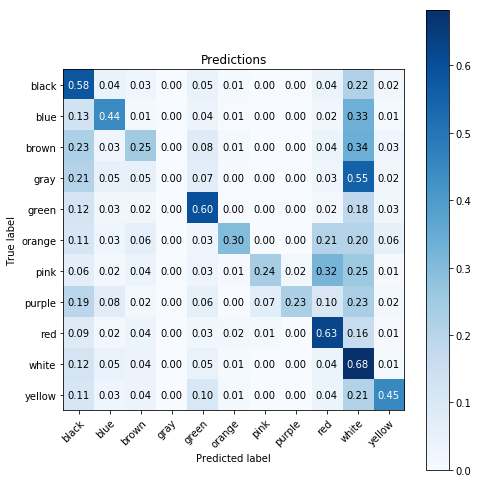

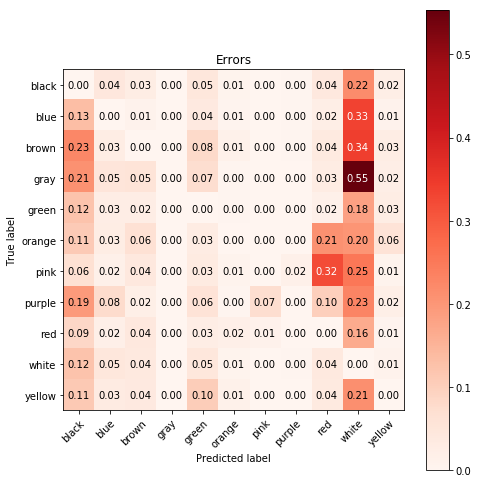

In [7]:
print ('Accuracy:', accuracy_score(y_validate.argmax(axis=1),predict_y.argmax(axis=1), normalize=True, sample_weight=None))
print (classification_report(y_validate.argmax(axis=1),predict_y.argmax(axis=1), 
                         labels=None, target_names=colors, sample_weight=None, digits=2, output_dict=False))
print ('Mean Reciprocal Rank:',label_ranking_average_precision_score(y_validate,predict_y),'\n')
evaluation.plot_confusion_matrix(y_validate.argmax(axis=1),predict_y.argmax(axis=1), colors, title='Predictions')
evaluation.plot_confusion_matrix(y_validate.argmax(axis=1),predict_y.argmax(axis=1), colors, error_matrix=True, cmap=plt.cm.Reds, title='Errors')

# Farben gleichverteilt im Train-Set durch Undersampling

In [8]:
input_file = 'baseline_arrays_bgr.npz'
import_arrays = np.load(data_dir+input_file)

x_train = import_arrays['train_x']
y_train = import_arrays['train_y']

# durch Random Undersampling: Farben gleichverteilen
rus = RandomUnderSampler(random_state=random_state)
x_train, y_train = rus.fit_resample(x_train, y_train[:,1:].argmax(axis=1))
# y_train von Integer zu One-Hot-Encoding
y_train = np.eye(num_classes)[y_train]
# IDs zu y_train hinzufügen
y_train = np.append(x_train[:,0:1], y_train, axis=1)

# exclude 1st column from every array (contains id)
x_train = x_train[:,1:]
y_train = y_train[:,1:]

print(x_train.shape[0], 'train samples')
print(x_validate.shape[0], 'validation samples')

71093 train samples
14494 validation samples


In [9]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_validate, y_validate))

score = model.evaluate(x_validate, y_validate, verbose=0)
predict_y = model.predict(x_validate)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.5302159113441152
Test accuracy: 0.5029667449010657


Accuracy: 0.5029667448599421
              precision    recall  f1-score   support

       black       0.36      0.49      0.41      1304
        blue       0.56      0.61      0.58      1394
       brown       0.39      0.46      0.42      1380
        gray       0.37      0.33      0.35      1329
       green       0.50      0.68      0.58      1348
      orange       0.63      0.49      0.55      1192
        pink       0.59      0.61      0.60      1354
      purple       0.69      0.56      0.62      1319
         red       0.53      0.56      0.55      1234
       white       0.36      0.19      0.25      1345
      yellow       0.65      0.53      0.59      1295

   micro avg       0.50      0.50      0.50     14494
   macro avg       0.51      0.50      0.50     14494
weighted avg       0.51      0.50      0.50     14494

Mean Reciprocal Rank: 0.6665692337039233 



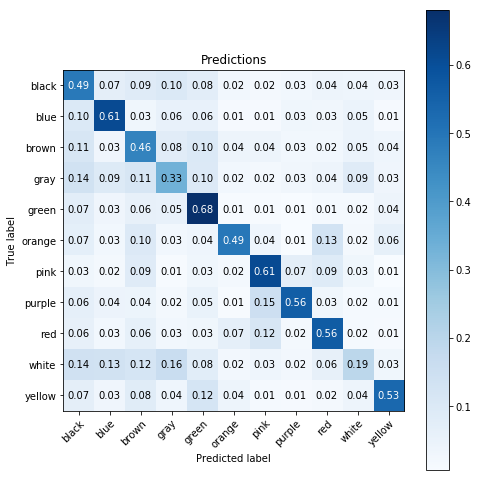

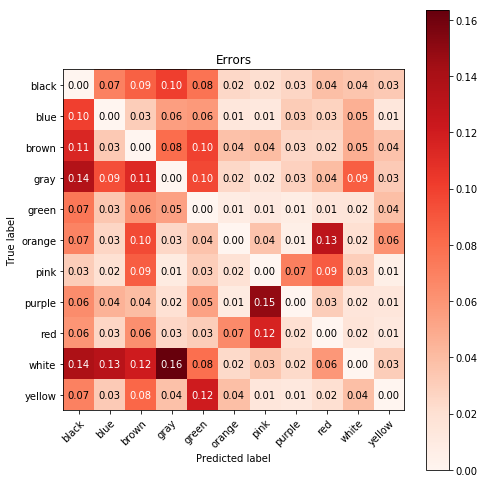

In [10]:
print ('Accuracy:', accuracy_score(y_validate.argmax(axis=1),predict_y.argmax(axis=1), normalize=True, sample_weight=None))
print (classification_report(y_validate.argmax(axis=1),predict_y.argmax(axis=1), 
                         labels=None, target_names=colors, sample_weight=None, digits=2, output_dict=False))
print ('Mean Reciprocal Rank:',label_ranking_average_precision_score(y_validate,predict_y),'\n')
evaluation.plot_confusion_matrix(y_validate.argmax(axis=1),predict_y.argmax(axis=1), colors, title='Predictions')
evaluation.plot_confusion_matrix(y_validate.argmax(axis=1),predict_y.argmax(axis=1), colors, error_matrix=True, cmap=plt.cm.Reds, title='Errors')

# Farben gleichverteilt im Train-Set durch Undersampling + Oversampling

In [11]:
from imblearn.over_sampling import RandomOverSampler


input_file = 'baseline_arrays_bgr.npz'
import_arrays = np.load(data_dir+input_file)

x_train = import_arrays['train_x']
y_train = import_arrays['train_y']

val = 10000

# Dict erzeugen mit Instanzen für einzelne Farbwörter
color_values = y_train[:,1:].argmax(axis=1)
color_values.shape = (len(color_values),1)
df = pd.DataFrame(np.append(y_train, color_values, axis=1))
color_counts_dict = dict(df.groupby([12]).size().reset_index(name='count').values)

# RandomOverSampler
ros = RandomOverSampler(random_state=123)

# Sample_DF initialisieren
sample_df = pd.DataFrame(columns=df.columns)

# Über Farbwerte iterieren
for i in list(range(0,num_classes)):
    # Maximalwert für jeweilige Farbe überprüfen
    color_count = len(df.loc[df[12] == i])
    # Anzahl der Samples: Gegebener Wert wenn kleiner/gleich Anzahl Farbinstanzen, sonst Anzahl Farbinstanzen; Samples zu sample_df
    n = (val if color_count >= val else color_count)
    sample_df = sample_df.append(df.loc[df[12] == i].sample(n, replace=False, random_state=123))

# OverSampling, wenn Anzahl Instanzen für ein Farbwort niedriger als gegebener Wert
ids = sample_df.to_numpy()[:,0].reshape(-1, 1)
ids_y = sample_df.to_numpy()[:,12].reshape(-1, 1)
ids_r, _ = ros.fit_resample(ids, ids_y)

# Einträge aus Input_Arrays auswählen, deren ID in sample_df ist
x_train = pd.merge(pd.DataFrame(x_train),pd.DataFrame(ids_r), on=0).to_numpy()
y_train = pd.merge(pd.DataFrame(y_train),pd.DataFrame(ids_r), on=0).to_numpy()

# exclude 1st column from every array (contains id)
x_train = x_train[:,1:]
y_train = y_train[:,1:]

print(x_train.shape[0], 'train samples')
print(x_validate.shape[0], 'validation samples')

/home/simeon/Dokumente/environments/ma-env/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


110000 train samples
14494 validation samples


In [12]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_validate, y_validate))

score = model.evaluate(x_validate, y_validate, verbose=0)
predict_y = model.predict(x_validate)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.511022923189113
Test accuracy: 0.5066234304261106


Accuracy: 0.5066234303849869
              precision    recall  f1-score   support

       black       0.34      0.53      0.42      1304
        blue       0.57      0.61      0.59      1394
       brown       0.39      0.46      0.42      1380
        gray       0.40      0.31      0.35      1329
       green       0.56      0.64      0.60      1348
      orange       0.64      0.50      0.56      1192
        pink       0.51      0.70      0.59      1354
      purple       0.70      0.56      0.62      1319
         red       0.55      0.55      0.55      1234
       white       0.36      0.17      0.23      1345
      yellow       0.64      0.55      0.59      1295

   micro avg       0.51      0.51      0.51     14494
   macro avg       0.51      0.51      0.50     14494
weighted avg       0.51      0.51      0.50     14494

Mean Reciprocal Rank: 0.6702915780844734 



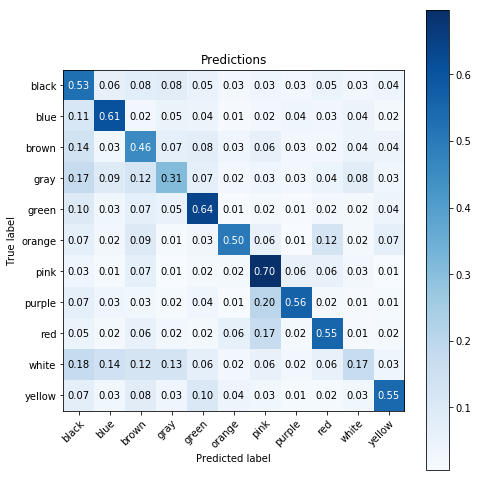

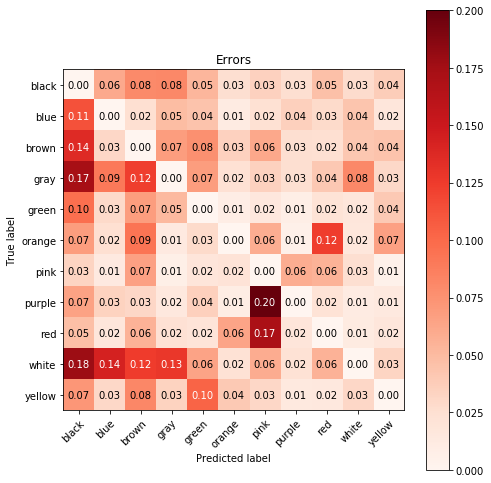

In [13]:
print ('Accuracy:', accuracy_score(y_validate.argmax(axis=1),predict_y.argmax(axis=1), normalize=True, sample_weight=None))
print (classification_report(y_validate.argmax(axis=1),predict_y.argmax(axis=1), 
                         labels=None, target_names=colors, sample_weight=None, digits=2, output_dict=False))
print ('Mean Reciprocal Rank:',label_ranking_average_precision_score(y_validate,predict_y),'\n')
evaluation.plot_confusion_matrix(y_validate.argmax(axis=1),predict_y.argmax(axis=1), colors, title='Predictions')
evaluation.plot_confusion_matrix(y_validate.argmax(axis=1),predict_y.argmax(axis=1), colors, error_matrix=True, cmap=plt.cm.Reds, title='Errors')

# Menschen raus aus Trainingsset und Testset

In [17]:
input_file = 'baseline_arrays_bgr.npz'
import_arrays = np.load(data_dir+input_file)

x_train = import_arrays['train_x']
y_train = import_arrays['train_y']

# durch Random Undersampling: Farben gleichverteilen
rus = RandomUnderSampler(random_state=random_state)
x_train, y_train = rus.fit_resample(x_train, y_train[:,1:].argmax(axis=1))
# y_train von Integer zu One-Hot-Encoding
y_train = np.eye(num_classes)[y_train]
# IDs zu y_train hinzufügen
y_train = np.append(x_train[:,0:1], y_train, axis=1)

# Filtern: Keine Menschen mehr im Train-Set
x_train = pd.DataFrame(x_train).loc[pd.DataFrame(x_train)[0].isin(no_person_index)].to_numpy()
y_train = pd.DataFrame(y_train).loc[pd.DataFrame(y_train)[0].isin(no_person_index)].to_numpy()
print ('Gleiche Indizes:', not False in (x_train[:,0] == y_train[:,0]))

# exclude 1st column from every array (contains id)
x_train = x_train[:,1:]
y_train = y_train[:,1:]

print(x_train.shape[0], 'train samples')
print(x_validate.shape[0], 'validation samples')

einträge:  (71093, 513)
Gleiche Indizes: True
63631 train samples
14494 validation samples


In [15]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_validate, y_validate))

score = model.evaluate(x_validate, y_validate, verbose=0)
predict_y = model.predict(x_validate)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.5115758284743415
Test accuracy: 0.5076583413661916


Accuracy: 0.5076583413826411
              precision    recall  f1-score   support

       black       0.37      0.51      0.43      1304
        blue       0.56      0.61      0.58      1394
       brown       0.41      0.43      0.42      1380
        gray       0.39      0.31      0.35      1329
       green       0.54      0.64      0.59      1348
      orange       0.52      0.63      0.57      1192
        pink       0.59      0.62      0.60      1354
      purple       0.69      0.60      0.64      1319
         red       0.56      0.51      0.53      1234
       white       0.33      0.17      0.22      1345
      yellow       0.60      0.57      0.59      1295

   micro avg       0.51      0.51      0.51     14494
   macro avg       0.50      0.51      0.50     14494
weighted avg       0.50      0.51      0.50     14494

Mean Reciprocal Rank: 0.6712149611194208 



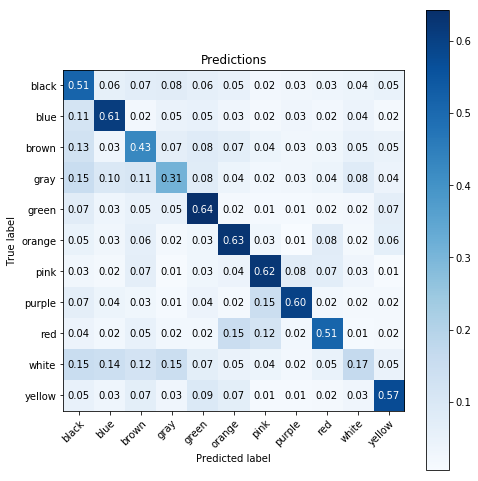

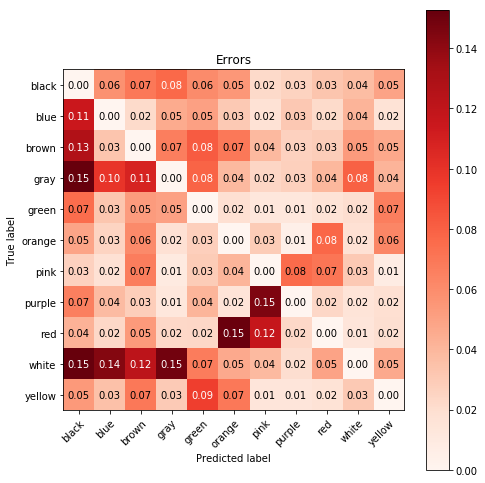

In [16]:
print ('Accuracy:', accuracy_score(y_validate.argmax(axis=1),predict_y.argmax(axis=1), normalize=True, sample_weight=None))
print (classification_report(y_validate.argmax(axis=1),predict_y.argmax(axis=1), 
                         labels=None, target_names=colors, sample_weight=None, digits=2, output_dict=False))
print ('Mean Reciprocal Rank:',label_ranking_average_precision_score(y_validate,predict_y),'\n')
evaluation.plot_confusion_matrix(y_validate.argmax(axis=1),predict_y.argmax(axis=1), colors, title='Predictions')
evaluation.plot_confusion_matrix(y_validate.argmax(axis=1),predict_y.argmax(axis=1), colors, error_matrix=True, cmap=plt.cm.Reds, title='Errors')